In [131]:
# Librerias
import os
from bs4 import BeautifulSoup, NavigableString
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import re
from threading import Thread
import queue

In [132]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
otherOutputFolder = "../2-data-preparation/1-input/main/"
logsFolder = "4-logs"

emailFolder = r"\main\email\iteration-"
emailIterationNumber = "6"
inputEmailFolder = inputFolder + emailFolder + emailIterationNumber

inputAzureAdFolder = inputFolder + r"\support\azure-ad"
inputCovidFolder = inputFolder + r"\support\covid"
inputEmailsFolder = inputFolder + r"\support\email"
inputGysAdFolder = inputFolder + r"\support\gys-ad"
inputHomeworkingFolder = inputFolder + r"\support\homeworking"

processMainFolder = processFolder + r"\main"
processSupportFolder = processFolder + r"\support"

dataVisualizationTopLimit = 20

sentitivities = [
  0, 
  0.72,  
  1
]

In [133]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

def readAndWriteSupport(folder, inputFile, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  with open(os.path.join(folder, inputFile), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(parseLineBreaksAndAccents(v)) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)
  
  return data

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

In [134]:
# Funciones principales
def getFiles(rootPath, source):
  # Obteniendo todas las carpetas de los perfiles
  folders = [f for f in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, f))]

  # Definiendo la lista de archivos final
  files = []

  # Iterando sobre las carpetas
  for folder in folders:
    # Obteniendo los archivos por cada carpeta
    folderFiles = [os.path.join(rootPath, folder, f) for f in os.listdir(os.path.join(rootPath, folder)) if os.path.isfile(os.path.join(rootPath, folder, f))]

    # Agregando esos archivos a la lista de archivos final
    if folderFiles:
      files.extend(folderFiles)
    
  print("Archivos totales: " + str(len(files)))
  
  if source == "illness":
    filesFilteredLimits = [f for f in files if ("\Solicitud de Enfermedad - " in f)]
    print("Archivos filtrados de enfermedad: " + str(len(filesFilteredLimits)))
  elif source == "permission":
    filesFilteredLimits = [f for f in files if ("\Solicitud de Permiso - " in f)]
    print("Archivos filtrados de permisos: " + str(len(filesFilteredLimits)))
  elif source == "vacation":
    filesFilteredLimits = [f for f in files if ("\Solicitud de Vacaciones - " in f)]
    print("Archivos filtrados de vacaciones: " + str(len(filesFilteredLimits)))
  else:
    # Filtros específicos por cada origen
    filteredFiles = [f for f in files if ("\Has recibido un CV para el aviso" in f)]
    
    print("Archivos filtrados solo con postulaciones: " + str(len(filteredFiles)))

    # Filtros para considerar un archivo especifico
    filterIsIn = [
      
    ]
    
    filesFilteredIsIn = [f for f in filteredFiles if ( f in filterIsIn if filterIsIn else True )]

    # Filtros para omitir un archivo especifico
    filterIsNotIn = [
      # 3 archivos con data incompleta (se mantiene en iteracion 4 y 5)
      inputEmailFolder + r"\bandeja-entrada-2022-focused\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html",
      inputEmailFolder + r"\bandeja-entrada-2022-focused\Has recibido un CV para el aviso _Analista Programador_(6).html",
      inputEmailFolder + r"\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html",
    ]

    filesFilteredNotIn = [f for f in filesFilteredIsIn if ( f not in filterIsNotIn if filterIsNotIn else True )]

    print("Archivos filtrados solo con data completa: " + str(len(filesFilteredNotIn)))

    # Limites superiores e inferiores en la búsqueda de archivos
    startLimit = None
    topLimit = None
    filesFilteredLimits = filesFilteredNotIn[(startLimit-1 if startLimit else 0): (topLimit if topLimit else len(files))]

  return filesFilteredLimits

In [135]:
def getEncodingBumeran(file):
  candidateLog = ""

  encoding = "windows-1252"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1252") as f:
        if "charset=windows-1252" in f.read():
          encoding = 'windows-1252'
        else:
          encoding = encoding
    except Exception as e:
      candidateLog = candidateLog + file + "\n"
      candidateLog = candidateLog + traceback.format_exc() + "\n"
      candidateLog = candidateLog + "\n"
      pass
      
  return encoding, candidateLog

In [136]:
def getCandidateBumeran(file, encoding, candidateLog):
  candidateData = {}
 
  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      soup = BeautifulSoup(myFile.read(), "lxml")

      # Obteniendo cada uno de los campos para la data

      # Fecha de postulación
      spanDates = soup.find_all("span", {"style": "color:black"})
      if len(spanDates) > 4:
        rawPostulationDate = spanDates[3].text
        postulationDate = datetime.datetime.strptime(spanDates[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanDates2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawPostulationDate = spanDates2[3].text
        postulationDate = datetime.datetime.strptime(spanDates2[3].text, "%A, %B %d, %Y %I:%M %p")
        
      candidateData["candidatePostulationDate"] = postulationDate.strftime("%A, %B %d, %Y %I:%M %p")

      # ID de la convocatoria
      TitleTagsText = soup.find("p", {"style": "margin-top:10.5pt;margin-right:0in;margin-bottom:10.5pt;margin-left:\n15.0pt;background:whitesmoke"}).findAll(string=True)
      cleanJobIdText = parseNames(parseLineBreaksAndAccents(TitleTagsText[3]))
      candidateData["jobId"] = cleanJobIdText[cleanJobIdText.find(":")+2:cleanJobIdText.find(")")]

      # Definiendo los colores a usar para las búsquedas según las fechas
      # En la fecha 2020-06-11 cambio el color de los titulos de cada sección
      inflexionDate = datetime.datetime(2020,6,11,12,5,0)
      colorTitle, colorSections = ("#008599", "#2192C9") if postulationDate <= inflexionDate else ("#E90066", "#0A26EE")

      # Nombre del perfil
      candidateData["jobProfileName"] = parseNames(parseLineBreaksAndAccents(soup.findAll("span", {"style": ("color:" + colorTitle) })[0].text))

      liTags = soup.find_all("ul", {"type": "disc"})[0].find_all("li")

      # Nombre del candidato
      firstLinePased = parseNames(parseLineBreaksAndAccents(liTags[0].text))
      candidateData["candidateFullName"] = firstLinePased
      
      # Pais de residencia
      expectedCivilStatusValues = ["Soltero/A", "Casado/A", "Divorciado/A", "Pareja De Hecho", "Viudo/A", "Union Libre"]
      secondLineParsed = parseNames(parseLineBreaksAndAccents(liTags[1].text))
      firstcommaIndex = secondLineParsed.find(",")
      if firstcommaIndex != -1:
        candidateData["candidateResidenceCountry"] = secondLineParsed[:firstcommaIndex]
      else:
        candidateData["candidateResidenceCountry"] = ""

      # Estado civil
      civilStatus = ""
      for value in expectedCivilStatusValues:
        if value in secondLineParsed:
          civilStatus = value
      candidateData["candidateCivilStatus"] = civilStatus

      # Numero de documento
      # Propiedad especial del rfind, el -1 coincide con el inicio del string, por lo que es lo mismo tomarlo con o sin el indice, en caso el index no sea -1
      lastSpaceIndex = secondLineParsed.rfind(" ")
      candidateData["candidateDocumentNumber"] = re.sub("[^0-9]", "", secondLineParsed[lastSpaceIndex+1:])
      
      # Fecha de nacimiento
      thirdLineParsed = parseNames(parseLineBreaksAndAccents(liTags[2].text))
      birthDate = thirdLineParsed[thirdLineParsed.find(":")+2:]
      if birthDate != "":
        candidateData["candidateBirthDate"] = datetime.datetime.strptime(thirdLineParsed[thirdLineParsed.find(":")+2:], "%d-%m-%Y").strftime("%Y-%m-%d")
      else:
        candidateData["candidateBirthDate"] = ""

      # Pais de nacimiento
      fourthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[3].text))
      candidateData["candidateBirthCountry"] = fourthLineParsed[fourthLineParsed.find(":")+2:]

      # Dirección
      fifthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[4].text))
      candidateData["candidateAddress"] = fifthLineParsed
    
      # Telefonos
      sixthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[5].text))
      candidateData["candidateHomeNumber"] = sixthLineParsed[sixthLineParsed.find("Tel.")+5:sixthLineParsed.find("/")]
      candidateData["candidateCellphoneNumber"] = sixthLineParsed[sixthLineParsed.find("/")+2:]

      # Correo
      seventhLineParsed = parseNames(parseLineBreaksAndAccents(liTags[6].text))
      candidateData["candidateEmail"] = seventhLineParsed

      mainDivTag = soup.find_all("div", {"style": 'background-position-x:50%;background-position-y:100%'})[0]
      mainChildTags = mainDivTag.find_all(recursive=False)
      sectionsIndexes = getSectionsIndexes(mainChildTags, colorSections)

      # Objetivo laboral, salario
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 0)
      if startIndex and endIndex:
        if (endIndex - startIndex) == 3:
          workObjectiveTag = mainChildTags[startIndex+2]
          candidateData["workObjetive"] = ""
          candidateData["salary"] = 0.0
          liTags = workObjectiveTag.find_all("li")
          for liTag in liTags:
            parsedText = parseNames(parseLineBreaksAndAccents(liTag.text))
            if "Objetivo Laboral:" in parsedText:
              candidateData["workObjetive"] = parsedText[parsedText.find("Objetivo Laboral: ")+18:]
            if "Sueldo Pretendido:" in parsedText:
              candidateData["salary"] = float(parsedText[parsedText.find("$")+1:parsedText.find(".")])
        else:
          candidateData["workObjetive"] = ""
          candidateData["salary"] = 0.0
      else:
        candidateData["workObjetive"] = ""
        candidateData["salary"] = 0.0
      
      # Experiencia laboral
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 1)

      if startIndex and endIndex:
        workExperienceTags = mainChildTags[startIndex+2:endIndex]
        
        # Iterando sobre todos los trabajos
        daysOfExperience = 0
        for index, firstRowIndex in enumerate(range(0, len(workExperienceTags), 2)):
          firstRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in workExperienceTags[firstRowIndex].find("span").findAll(string=True)]
          secondRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in workExperienceTags[firstRowIndex+1].find("p").findAll(string=True)]
          workStartDateText = firstRowTagsValues[0][:firstRowTagsValues[0].find(" - ")]
          workStartDate = datetime.datetime.strptime(workStartDateText, "%d-%m-%Y")
          workEndDateText = firstRowTagsValues[0][firstRowTagsValues[0].find(" - ")+3:firstRowTagsValues[0].find(" |")]
          workEndDate = datetime.datetime.strptime(workEndDateText, "%d-%m-%Y") if workEndDateText != "Presente" else postulationDate
          daysOfWork = abs((workEndDate - workStartDate).days)
          daysOfExperience = daysOfExperience + daysOfWork
          # Obteniendo datos del último trabajo
          if index == 0:
            candidateData["lastWorkDays"] = float(daysOfWork)
            candidateData["lastWorkCompany"] = firstRowTagsValues[1]
            candidateData["lastWorkCountry"] = firstRowTagsValues[2][:firstRowTagsValues[2].find(".")]
            candidateData["lastWorkArea"] = firstRowTagsValues[2][firstRowTagsValues[2].find(".")+2:firstRowTagsValues[2].rfind(".")]
            candidateData["lastWorkName"] = secondRowTagsValues[0]
            candidateData["lastWorkDescription"] = secondRowTagsValues[1] if len (secondRowTagsValues) > 1 else ""
        candidateData["yearsOfExperience"] = round(float(daysOfExperience/365),1)
        candidateData["worksNumber"] = float(len(workExperienceTags)/2)
      else:
        candidateData["lastWorkDays"] = 0.0
        candidateData["lastWorkCompany"] = ""
        candidateData["lastWorkCountry"] = ""
        candidateData["lastWorkArea"] = ""
        candidateData["lastWorkName"] = ""
        candidateData["lastWorkDescription"] = ""
        candidateData["yearsOfExperience"] = 0.0
        candidateData["worksNumber"] = 0.0
            
      # Carrera profesional (última alcanzada)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 2)
      if startIndex and endIndex:
        educationTags = mainChildTags[startIndex+2:endIndex]
        # Iterando sobre todos las educaciones
        daysOfStudy = 0
        for index, firstRowIndex in enumerate(range(0, len(educationTags), 2)):
          firstRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in educationTags[firstRowIndex].findAll(string=True)]
          secondRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in educationTags[firstRowIndex+1].find("p").findAll(string=True)]
          educationStartDateText = firstRowTagsValues[0][:firstRowTagsValues[0].find(" - ")]
          educationStartDate = datetime.datetime.strptime(educationStartDateText, "%d-%m-%Y")
          educationEndDateText = firstRowTagsValues[0][firstRowTagsValues[0].find(" - ")+3:firstRowTagsValues[0].find(" |")]
          educationEndDate = datetime.datetime.strptime(educationEndDateText, "%d-%m-%Y") if educationEndDateText != "Presente" else postulationDate
          daysOfEducation = abs((educationEndDate - educationStartDate).days)
          daysOfStudy = daysOfStudy + daysOfEducation
          # Obteniendo datos del último trabajo
          if index == 0:
            # Se analizo cada caso con esto: candidateData["str"] = str(firstRowTagsValues) candidateData["len"] = len(firstRowTagsValues)
            candidateData["lastEducationDays"] = float(daysOfEducation)
            # Caso en el que no están ni el bold del company ni del area
            if len(firstRowTagsValues) == 1:
              candidateData["lastEducationCompany"] = ""
              candidateData["lastEducationCountry"] = firstRowTagsValues[0][firstRowTagsValues[0].find(",")+2:firstRowTagsValues[0].find(".")]
              candidateData["lastEducationArea"] = ""
            
            # En este caso, el bold del company se va, o el bold del area se va
            elif len(firstRowTagsValues) == 3:  
              # Primer caso
              if "," in firstRowTagsValues[0]:
                candidateData["lastEducationCompany"] = ""
                candidateData["lastEducationCountry"] = firstRowTagsValues[0][firstRowTagsValues[0].find(",")+2:firstRowTagsValues[0].find(".")]
                candidateData["lastEducationArea"] = firstRowTagsValues[1]
              # Segundo caso
              else:
                candidateData["lastEducationCompany"] = firstRowTagsValues[1]
                candidateData["lastEducationCountry"] = firstRowTagsValues[2][firstRowTagsValues[2].find(",")+2:firstRowTagsValues[2].find(".")]
                candidateData["lastEducationArea"] = ""
            # Caso atípico (solo un caso)
            elif len(firstRowTagsValues) == 6:
              candidateData["lastEducationCompany"] = firstRowTagsValues[2]
              candidateData["lastEducationCountry"] = firstRowTagsValues[3][firstRowTagsValues[3].find(",")+2:firstRowTagsValues[3].find(".")]
              candidateData["lastEducationArea"] = firstRowTagsValues[4]
            # Caso comun (esta todo)
            else:
              candidateData["lastEducationCompany"] = firstRowTagsValues[1]
              candidateData["lastEducationCountry"] = firstRowTagsValues[2][firstRowTagsValues[2].find(",")+2:firstRowTagsValues[2].find(".")]
              candidateData["lastEducationArea"] = firstRowTagsValues[3]
            
            #candidateData["str"] = str(secondRowTagsValues) candidateData["len"] = len(secondRowTagsValues)
            
            firstElemSecondRow = parseNames(parseLineBreaksAndAccents(" ".join(secondRowTagsValues[0:-1])))
            secondElemSecondRow = secondRowTagsValues[-1]
            
            candidateData["lastEducationName"] = firstElemSecondRow
            candidateData["lastEducationStatus"] = secondElemSecondRow[secondElemSecondRow.find(",")+2:secondElemSecondRow.rfind(",")]
            candidateData["lastEducationDegree"] = secondElemSecondRow[secondElemSecondRow.rfind(",")+2:secondElemSecondRow.find(".")]
        candidateData["yearsOfStudy"] = round(float(daysOfStudy/365),1)
        candidateData["studiesNumber"] = float(len(educationTags)/2)
      else:
        candidateData["lastEducationDays"] = 0.0
        candidateData["lastEducationCompany"] = ""
        candidateData["lastEducationCountry"] = ""
        candidateData["lastEducationArea"] = ""
        candidateData["lastEducationName"] = ""
        candidateData["lastEducationStatus"] = ""
        candidateData["lastEducationDegree"] = ""
        candidateData["yearsOfStudy"] = 0.0
        candidateData["studiesNumber"] = 0.0
      
      # Habilidades técnicas
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 3)
      #print(startIndex, endIndex)
      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["technicalSkills"] = float(len(liTags))
      else:
        candidateData["technicalSkills"] = 0.0
      
      # Lenguajes
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 4)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["languages"] = float(len(liTags))
      else:
        candidateData["languages"] = 0.0

      # Otros conocimientos (habilidades blandas)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 5)

      if startIndex and endIndex:
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["otherSkills"] = float(len(liTags))
      else:
        candidateData["otherSkills"] = 0.0

  except Exception as e:
    candidateData = {}
    candidateLog = candidateLog + str(file) + "\n"
    candidateLog = candidateLog + traceback.format_exc() + "\n"
    candidateLog = candidateLog + "\n"
    pass

  return candidateData, candidateLog

In [137]:
class Worker(Thread):
  def __init__(self, queue, filesCount):
    Thread.__init__(self)
    self.queue = queue
    self.filesCount = filesCount
    self.candidateData = []
    self.candidateLog = []

  def run(self):
    while True:
      elem = self.queue.get()
      if not elem:
        break
      
      index, file = elem["index"], elem["file"]

      if index % 500 == 0:
        print(str(index) + "/" + str(self.filesCount) + " archivos analizados")
      
      # Obteniendo el encoding por cada archivo
      encoding, candidateLog = getEncodingBumeran(file)

      # Obteniendo los datos por cada archivo
      candidateData, candidateLog = getCandidateBumeran(file, encoding, candidateLog)
      
      if candidateData:
        self.candidateData.append(candidateData)
      if candidateLog:
        self.candidateLog.append(candidateLog)

      self.queue.task_done()

In [138]:
def iterateCandidateQueue(files, workersNumber):
  filesCount = len(files)

  q = queue.Queue()
  for index, file in enumerate(files):
    q.put({"index": index, "file": file})
  
  for _ in range(workersNumber):
    q.put({})
  
  workers = []
  for _ in range(workersNumber):
      worker = Worker(q, filesCount)
      worker.start()
      workers.append(worker)
  
  for worker in workers:
      worker.join()
  
  data = []
  log = ""
  for worker in workers:
    data.extend(worker.candidateData)
    log = log + "".join(worker.candidateLog)

  return data, log

In [139]:
def readAndWriteMain(source):
  # Definiendo la carpeta raiz de los archivos a buscar, según el origen
  rootPath = inputEmailFolder

  # Obteniendo la lista de archivos, según el origen
  files = getFiles(rootPath, source)

  # Definiendo el numero de hilos
  workersNumber = 1

  # Obteniendo los datos de candidatos y el log
  data, log = iterateCandidateQueue(files, workersNumber)

  # Realizando un ordenamiento por fecha de postulación, en orden descendente
  data = sorted(data, key=lambda x: (x["candidatePostulationDate"]), reverse=True)

  # Escribiendo la data de los candidatos (json y csv)
  writeJson(data, os.path.join(processMainFolder, source + '.json'))
  writeCsv(data, os.path.join(processMainFolder, source + '.csv'))

  # Escribiendo el log de errores
  writeTxt(log, os.path.join(logsFolder, source, datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".txt"), 'utf-16')

  return data

In [140]:
def readAndWriteRequests(source, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  files = getFiles(inputEmailFolder, source)

  employees = []
  
  for file in files:
    # Detectar si tienen el To: en el texto
    try:
      with open(file, "r", encoding=readEncoding) as f:
        soup = BeautifulSoup(f.read(), "lxml")
        pTags = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif'})
        employee = parseNames(parseLineBreaksAndAccents(pTags[1].text))
        #print(employee)
        if employee not in employees:
          employees.append(employee)
    except Exception as e:
      print(file)
      traceback.print_exc()
      print()
      pass

  data = [ {"fullName": parseNames(employee)} for employee in employees ]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

  return data

In [141]:
def readAndWriteTaggedData(preprocessedData, emailsData, covidData, gysAdData, azureAdData, homeworkingData, illnessData, permissionData, vacationData):
  # Definiendo arrays con el nombre
  comparations = [
    getCompare(emailsData, ["primerNombre", "apellidoPaterno"]),
    getCompare(emailsData, ["segundoNombre", "apellidoPaterno"]),
    getCompare(emailsData, ["primerNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(emailsData, ["segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(emailsData, ["primerNombre", "segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["primerNombre", "apellidoPaterno"]),
    getCompare(covidData, ["segundoNombre", "apellidoPaterno"]),
    getCompare(covidData, ["primerNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["primerNombre", "segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(gysAdData, ["Nombre para mostrar"]),
    getCompare(gysAdData, ["Nombre", "Apellido"]),
    getCompare(azureAdData, ["displayName"]),
    getCompare(azureAdData, ["givenName", "surname"]),
    getCompare(homeworkingData, ["primerNombre", "apellidoPaterno"]),
    getCompare(homeworkingData, ["segundoNombre", "apellidoPaterno"]),
    getCompare(homeworkingData, ["primerNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(homeworkingData, ["segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(homeworkingData, ["primerNombre", "segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(illnessData, ["fullName"]),
    getCompare(permissionData, ["fullName"]),
    getCompare(vacationData, ["fullName"]),
  ]

  for index, candidate in enumerate(preprocessedData):
    if (index % 500 == 0):
      print(str(index) + "/" + str(len(preprocessedData)) + " registros analizados")
    
    arrayComparations = []
    for compare in comparations:
      for elem in compare:
        distance = jellyfish.jaro_distance(candidate["candidateFullName"], elem)
        arrayComparations.append(distance)

    maxDistance = max(arrayComparations)
    for i in range (0, len(sentitivities) - 1):
      if i == 0:
        if (sentitivities[i] <= maxDistance and maxDistance <= sentitivities[i+1]):
          candidate["hired"] = i
      else:
        if (sentitivities[i] < maxDistance and maxDistance <= sentitivities[i+1]):
          candidate["hired"] = i
  
  writeJson(preprocessedData, os.path.join(outputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(outputFolder, 'result.csv'), 'utf-8')
  
  writeJson(preprocessedData, os.path.join(otherOutputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(otherOutputFolder, 'result.csv'), 'utf-8')

  return preprocessedData

In [142]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.dtypes)
  print(df.count())

  columns = [columnName for columnName in df.columns]
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "object" ]
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "float64" ]

  for column in columns:
    if column in numericalColumns:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()
    else:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()

Inicio: 2023-05-25 03:17:36.394151
Se inició el procesamiento
Se terminó de procesar Bumeran
Se terminó de procesar azureAd
Se terminó de procesar covid
Se terminó de procesar email
Se terminó de procesar gysAd
Se terminó de procesar Homeworking
Se terminó de procesar Illness
Se terminó de procesar Permission
Se terminó de procesar Vacation
0/10597 registros analizados
500/10597 registros analizados
1000/10597 registros analizados
1500/10597 registros analizados
2000/10597 registros analizados
2500/10597 registros analizados
3000/10597 registros analizados
3500/10597 registros analizados
4000/10597 registros analizados
4500/10597 registros analizados
5000/10597 registros analizados
5500/10597 registros analizados
6000/10597 registros analizados
6500/10597 registros analizados
7000/10597 registros analizados
7500/10597 registros analizados
8000/10597 registros analizados
8500/10597 registros analizados
9000/10597 registros analizados
9500/10597 registros analizados
10000/10597 registros

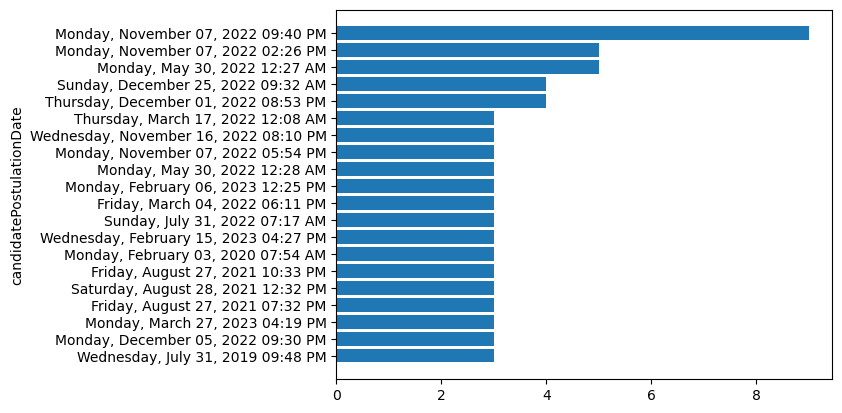

1115485533    387
1113709766    359
1114632424    358
1114632432    354
1115375308    217
1115718250    192
1115650381    187
1113930394    140
1115705134    131
1115538054    128
1113663856    122
1115628276    119
1115673897    116
1115693060    116
1115338587    108
1115460734    107
1115720649    106
1114047548    103
1115722853    101
1115644833    100
Name: jobId, dtype: int64


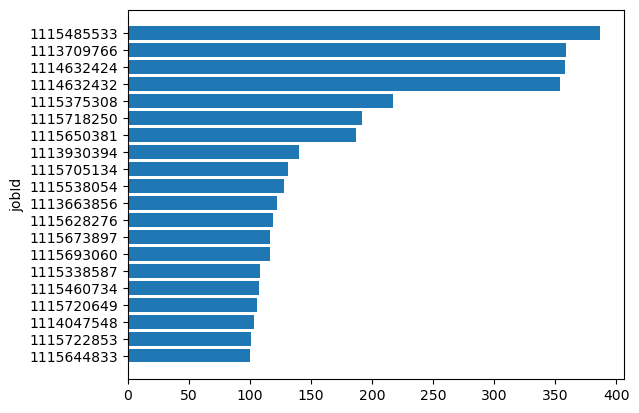

Practicante De Recursos Humanos                    962
Analista Funcional                                 599
Ejecutivo Comercial                                444
Gestor De Servicios De Ti                          359
Asistente De Recursos Humanos                      354
Asistente Social                                   315
Jefe De Proyecto - Analytics & Ai                  294
Practicante De Infrastructure & Cloud              279
Programador .Net                                   275
Analista Programador                               255
Asistente De Pmo                                   243
Community Manger                                   187
Desarrollador .Net                                 181
Analista De Calidad                                177
Ejecutivo(A) Comercial Ti                          160
Jefe De Proyectos - Analytics & Ai                 152
Lider Tecnico                                      148
Jefe De Proyecto Para El Area De Analytics & Ai    140
Cloud Spec

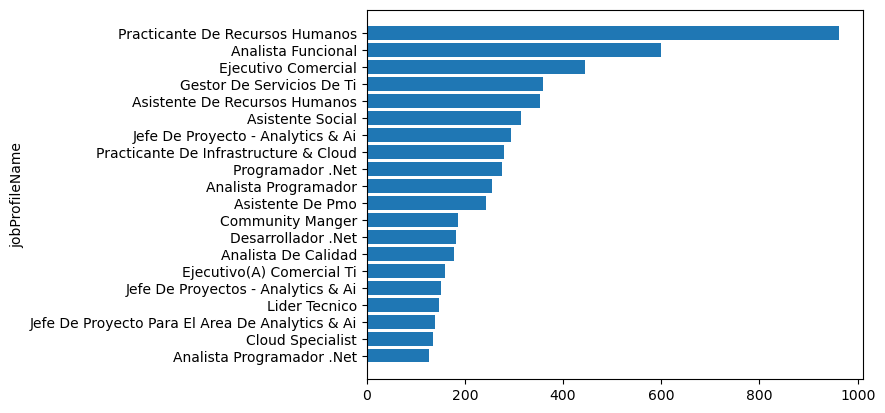

Jorge Urquia Malaver                     80
Henry Fernando Terrones Cortez           42
Antonio Miranda Cuadros                  35
Julia Elizabeth Villa Morales            27
Gaston Ibanez Perez                      24
Alejandra Lourdes Vargas Cumpa           22
Francisco Jose Reyes Tapia               18
Luis Quispe                              18
Andy Olortegui Espiritu                  17
Gianfranco Herrera Mostacero             17
Eduardo Passano                          15
John Antohny Panana Chumpitaz            15
Renato Meza Cribilleros                  15
Willy Francis Olortegui Arauzo           14
Guillermo Daniel Herencia Valdivieso     13
Alexander Martin Chacon Cobenas          13
Rosa Luz Huirse Torres                   13
Elias Obeso Valverde                     12
Peter Jonathan Rivera Del Carpio Baca    12
Randy Silva Salazar                      12
Name: candidateFullName, dtype: int64


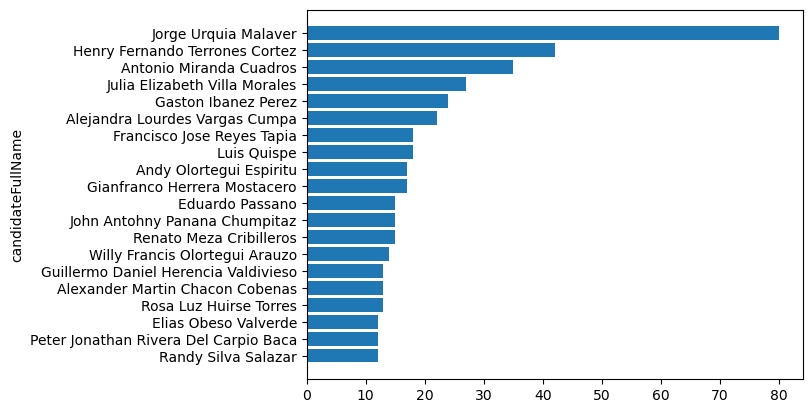

Peru                    10348
Venezuela                 148
                           64
Argentina                  11
Colombia                    9
Brasil                      4
Ecuador                     3
Republica Dominicana        2
Chile                       2
El Salvador                 1
Espana                      1
Bolivia                     1
Francia                     1
Panama                      1
Costa Rica                  1
Name: candidateResidenceCountry, dtype: int64


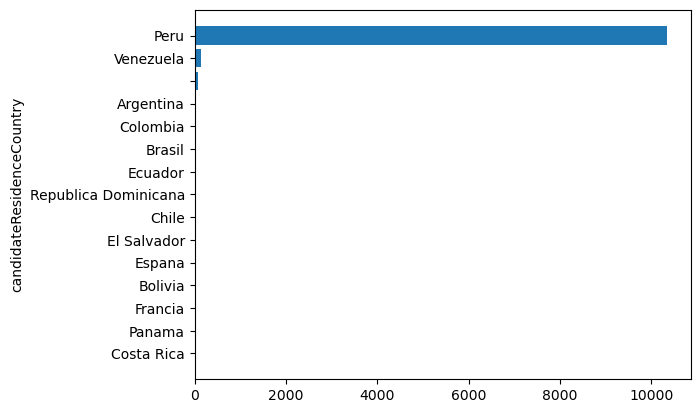

Soltero/A          8120
Casado/A           1554
                    634
Divorciado/A        130
Pareja De Hecho     110
Union Libre          46
Viudo/A               3
Name: candidateCivilStatus, dtype: int64


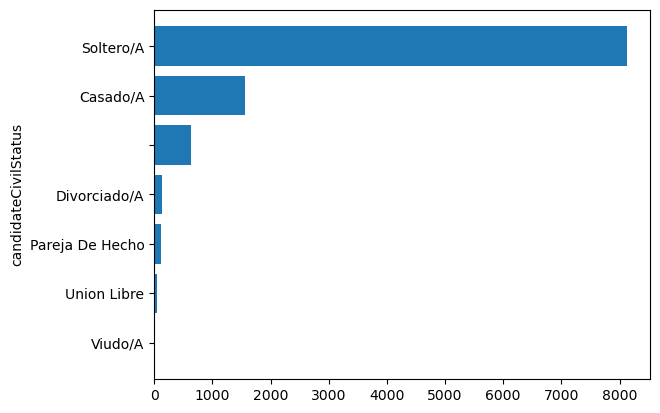

            272
43319681     80
43462768     35
43015660     27
41002160     27
18229064     24
45732690     22
10315458     18
45419217     17
44174897     17
46596341     15
42030318     15
12345678     15
40613584     15
70008340     14
07968889     13
46688979     13
44178991     13
47088768     13
45941486     12
Name: candidateDocumentNumber, dtype: int64


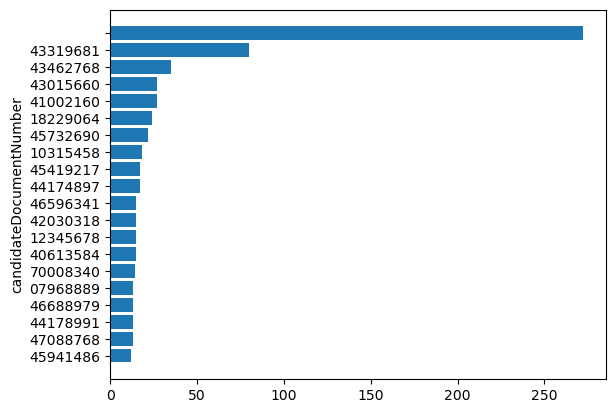

              233
1985-07-13     86
1979-09-30     42
1985-04-08     27
1986-01-18     25
1978-01-21     24
1989-02-25     23
1987-04-13     19
1990-12-15     18
1990-09-11     18
1975-05-15     18
1988-11-18     17
1980-07-24     16
1982-10-16     15
1990-02-24     15
1988-08-17     14
1968-10-29     13
1987-01-01     13
1992-03-13     13
1984-03-04     12
Name: candidateBirthDate, dtype: int64


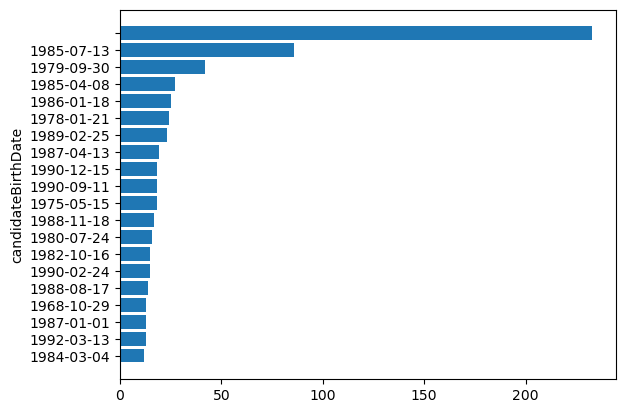

Peru                    10348
Venezuela                 148
                           64
Argentina                  11
Colombia                    9
Brasil                      4
Ecuador                     3
Republica Dominicana        2
Chile                       2
El Salvador                 1
Espana                      1
Bolivia                     1
Francia                     1
Panama                      1
Costa Rica                  1
Name: candidateBirthCountry, dtype: int64


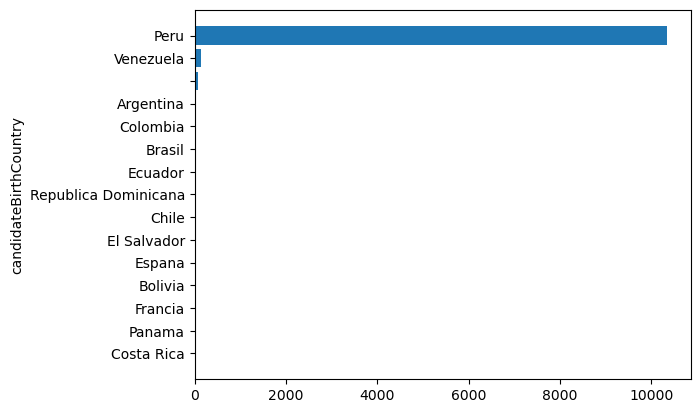

                                                                                        676
Lima, Lima, Lima, Peru                                                                   80
Neruda, Lima, Lima, Peru                                                                 47
., Lima, Lima, Peru                                                                      33
Jr Ica 950, Lima, Lima, Peru                                                             26
Santa Anita , Lima, Lima, Peru                                                           25
Calle Valladolid # 128 Urbanizacion Mayorazgo - Ate, Ate, Lima, Peru                     25
Calle 13 De Abril 910, Arequipa, Arequipa, Peru                                          22
Calera De La Merced 248, Surquillo, Lima, Peru                                           21
Begonias, Carabayllo, Lima, Peru                                                         18
-, Lima, Lima, Peru                                                             

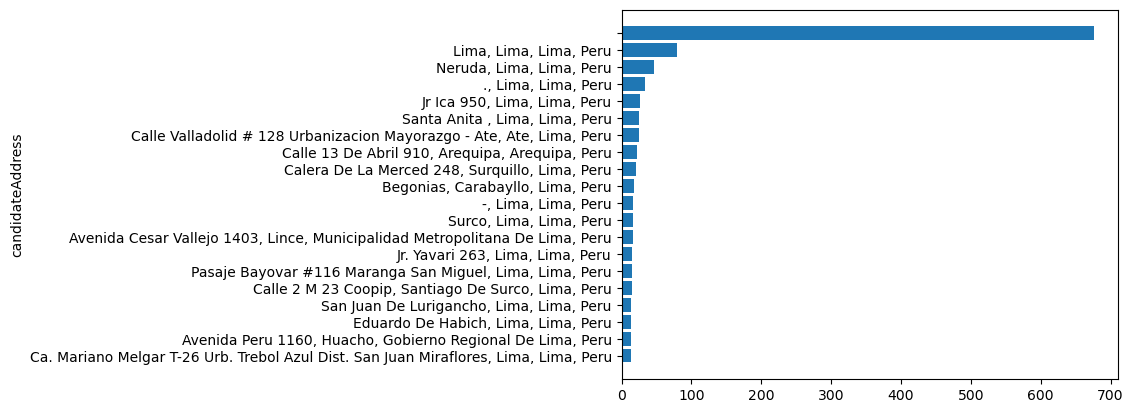

                 5121
51                715
+                 140
01                 79
511                63
51 910984054       46
51 931810142       25
+51                18
511 5748571        15
51 995384149       13
5775611 01         12
01 2580077         12
51 993596249       11
511 4342693        11
01 0               11
01 3997952          9
51 5611445          9
01 4643843          9
001 5710744         9
051 7473619         9
Name: candidateHomeNumber, dtype: int64


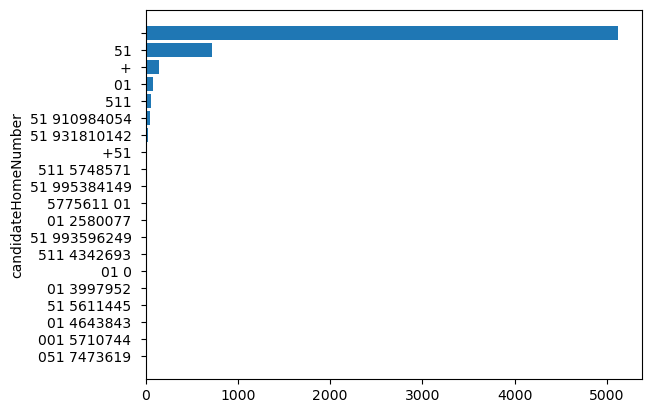

                  81
51 910984054      46
511 949346218     27
51 931810142      25
054 973583947     22
+51 950001939     21
51 994637675      18
51 997671135      15
511 992028085     15
51 949346218      15
51 940442936      15
0511 933480280    14
51 995384149      13
01 959053787      13
511 946059246     13
51 991064075      12
951901566         12
51 954775066      11
51 993596249      11
511 958960663     11
Name: candidateCellphoneNumber, dtype: int64


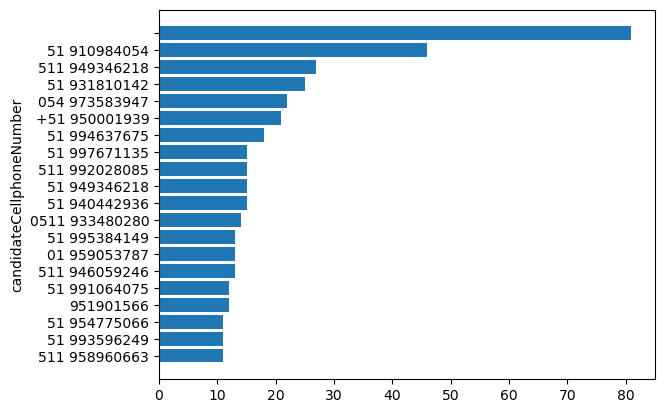

Jurqui29@Outlook.Com            80
Hcortez2011@Gmail.Com           42
Amirandac36@Gmail.Com           35
Villamoralesjulia@Gmail.Com     27
Gastoni21@Hotmail.Com           24
Alevca@Hotmail.Com              22
Paco150575@Hotmail.Com          18
Ricardo_I14@Hotmail.Com         18
Leono13@Live.Com                17
Asistemas200920341@Gmail.Com    17
Renato.Mzc1990@Gmail.Com        15
John.Panana@Gmail.Com           15
Eduardopassano82@Hotmail.Com    15
Willy.Olortegui@Gmail.Com       14
Guillermoherenciav@Gmail.Com    13
Alez1512@Hotmail.Com            13
Rosa.Huirset@Gmail.Com          13
Pjrcb@Yahoo.Es                  12
Nirvana_566@Hotmail.Com         12
Randy.Silva@Gmail.Com           11
Name: candidateEmail, dtype: int64


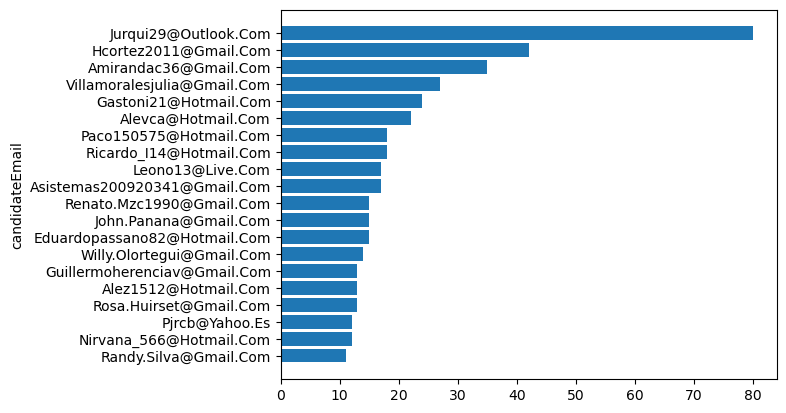

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          1318
Me Desempeno En El Area D

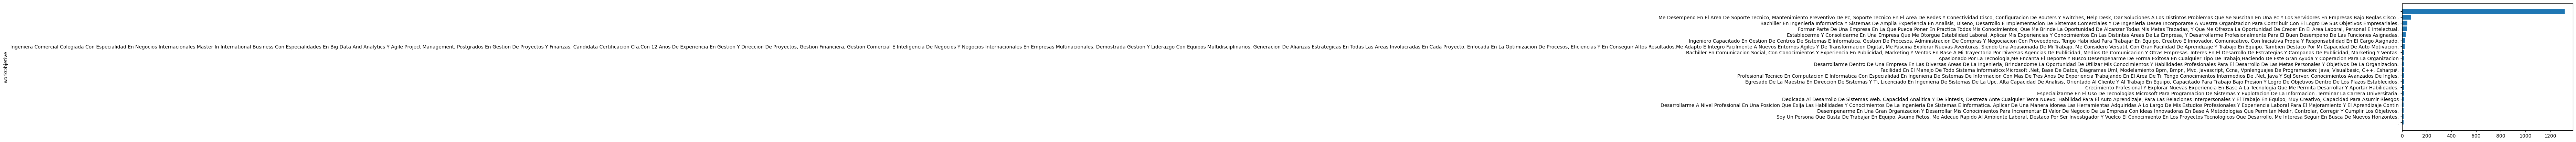

5000.0    641
2500.0    639
2000.0    601
3500.0    593
3000.0    574
4000.0    560
1500.0    484
6000.0    463
0.0       439
4500.0    434
1200.0    364
1800.0    360
5500.0    326
6500.0    305
1025.0    298
7000.0    296
1000.0    282
930.0     227
1.0       210
8000.0    208
Name: salary, dtype: int64


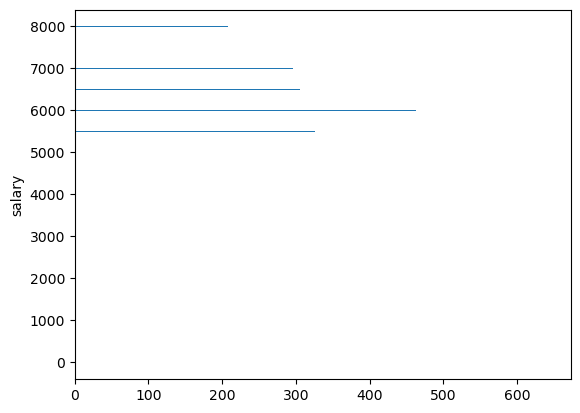

0.0      604
153.0    167
61.0     165
92.0     156
122.0    152
365.0    140
184.0    105
212.0     98
31.0      88
91.0      87
214.0     87
151.0     84
181.0     83
334.0     82
273.0     76
183.0     70
59.0      66
275.0     65
366.0     63
243.0     59
Name: lastWorkDays, dtype: int64


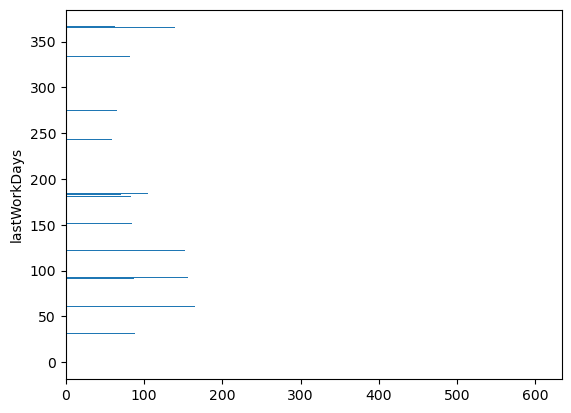

                                            568
Canvia                                      144
Freelance (Clientes)                         80
Global Hitss                                 79
Everis                                       61
Independiente                                59
Mdp Consulting                               59
Indra                                        54
Tata Consultancy Services                    42
Banco De Credito Del Peru                    39
Everis Peru Sac                              33
Everis Peru                                  27
Pontificia Universidad Catolica Del Peru     27
Panacea Consultores S.A.                     26
Tgestiona                                    25
Experis                                      25
Onpe                                         25
Interbank                                    24
Sapia                                        23
Mdp                                          22
Name: lastWorkCompany, dtype: int64


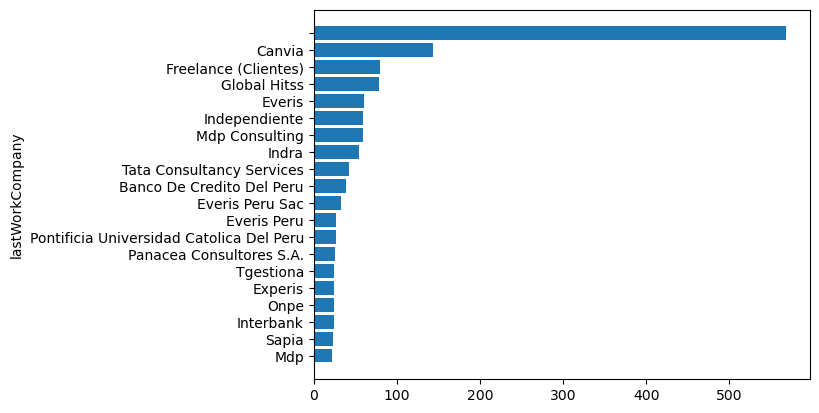

Peru              9850
                   568
Estados Unidos      32
Espana              25
Venezuela           25
Colombia            17
Brasil              16
Chile               13
Argentina            7
Ecuador              7
Mexico               4
Reino Unido          3
Albania              3
Costa Rica           3
Australia            2
Panama               2
Italia               2
Francia              2
Finlandia            2
Paises Bajos         2
Name: lastWorkCountry, dtype: int64


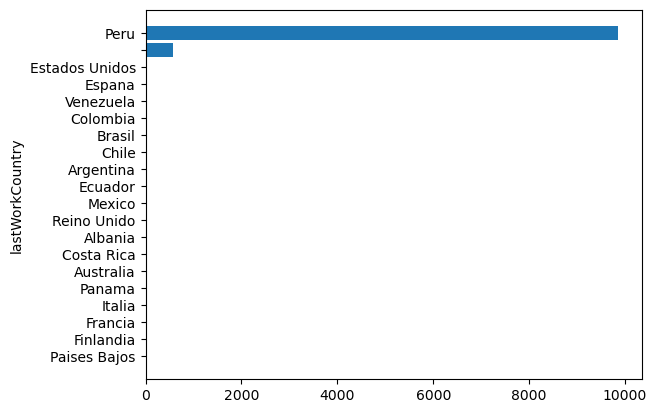

Tecnologia / Sistemas            1095
Tecnologias De La Informacion    1058
Liderazgo De Proyecto             615
Programacion                      596
                                  568
Comercial                         557
Sistemas                          504
Recursos Humanos                  453
Analisis Funcional                294
Ventas                            268
Administracion                    266
Analisis De Datos                 244
Infraestructura                   216
Soporte Tecnico                   209
Atencion Al Cliente               167
Seguridad Informatica             163
Otras Ingenierias                 157
Testing / Qa / Qc                 138
Desarrollo De Negocios            132
Telecomunicaciones                125
Name: lastWorkArea, dtype: int64


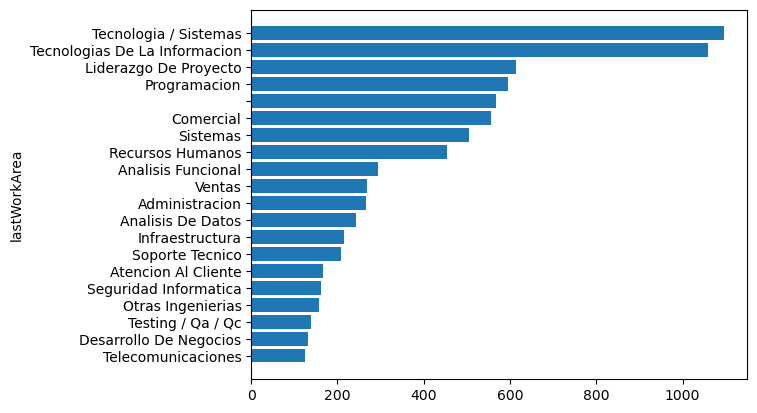

                                                568
Analista Programador                            406
Analista De Sistemas                            196
Analista Funcional                              174
Jefe De Proyectos                                87
Trabajadora Social                               87
Supervisor De Infraestructura De Redes Cisco     80
Asistente Administrativo                         69
Project Manager                                  58
Asesor Comercial                                 54
Analista                                         53
Practicante                                      51
Ejecutivo Comercial                              50
Asistente De Recursos Humanos                    49
Analista De Sistemas Senior                      47
Jefe De Sistemas                                 39
Key Account Manager                              39
Asistenta Social                                 39
Programador                                      39
Soporte Tecn

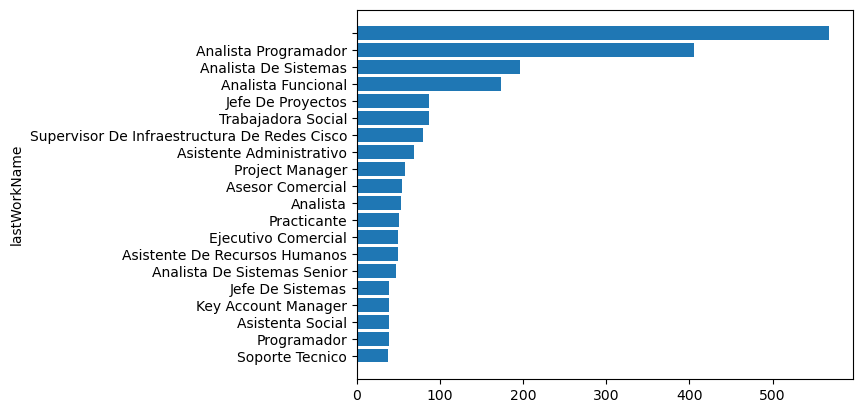

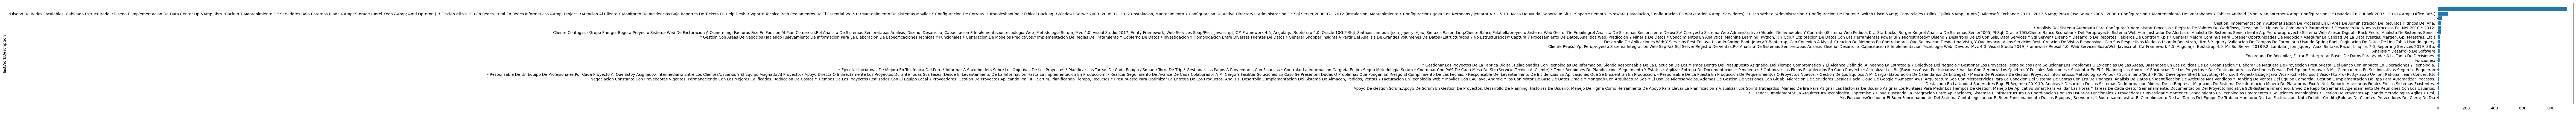

0.0    575
4.8    106
4.3    106
8.8     98
5.8     94
0.2     93
2.8     91
1.9     90
6.8     88
5.9     85
7.3     83
8.4     83
7.7     83
1.2     81
1.0     79
0.5     79
8.3     79
7.0     79
6.3     79
2.9     78
Name: yearsOfExperience, dtype: int64


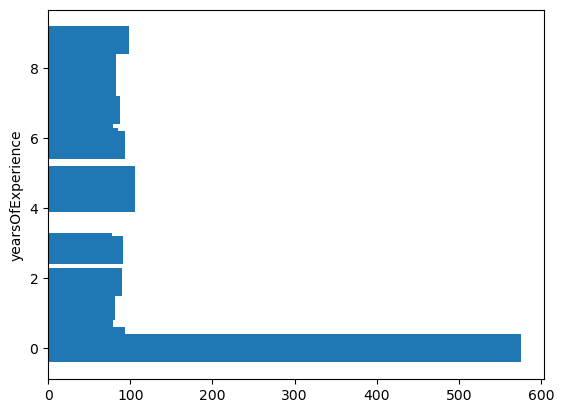

5.0     1335
4.0     1229
6.0     1113
3.0     1050
7.0      984
8.0      758
2.0      749
1.0      672
0.0      568
9.0      558
10.0     422
11.0     289
12.0     251
13.0     157
14.0     128
15.0      99
17.0      63
16.0      48
19.0      40
18.0      32
Name: worksNumber, dtype: int64


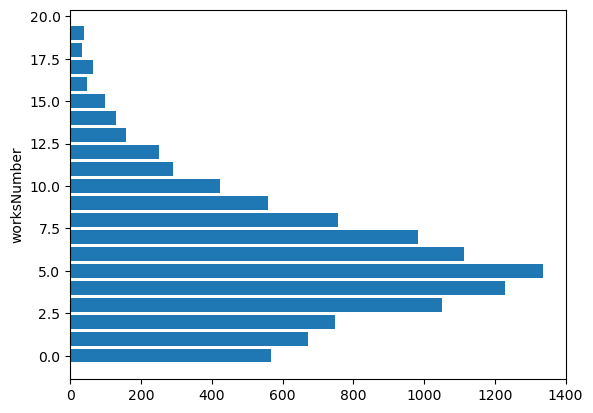

0.0       727
31.0      322
61.0      252
30.0      220
1736.0    204
92.0      162
1705.0    148
122.0     148
1948.0    132
153.0     124
2101.0    106
1795.0    105
91.0       87
1826.0     82
183.0      67
2161.0     65
1096.0     64
1157.0     64
1218.0     62
2070.0     61
Name: lastEducationDays, dtype: int64


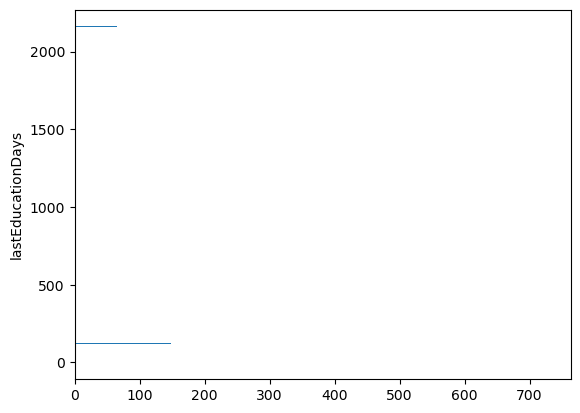

Universidad Peruana De Ciencias Aplicadas    585
Universidad Tecnologica Del Peru             363
Pontificia Universidad Catolica Del Peru     342
Universidad Nacional Mayor De San Marcos     308
Universidad Privada Del Norte                304
Upc                                          300
Universidad Esan                             245
Universidad Cesar Vallejo                    232
Universidad De Lima                          227
Cibertec                                     222
Universidad Nacional De Ingenieria           206
Instituto Cibertec                           205
Universidad De San Martin De Porres          198
                                             191
Universidad Ricardo Palma                    191
Universidad Nacional Federico Villarreal     189
Universidad Inca Garcilaso De La Vega        173
Utp                                          168
Isil                                         168
Universidad San Ignacio De Loyola            141
Name: lastEducationC

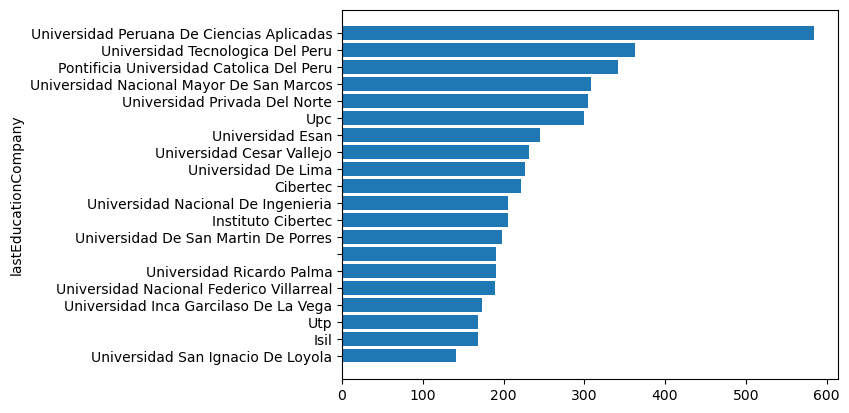

Peru              9841
Espana             205
Venezuela          165
                   128
Estados Unidos      78
Mexico              34
Argentina           21
Colombia            20
Brasil              19
Chile               18
Costa Rica          14
Canada               8
Australia            6
Bolivia              6
Ecuador              6
Francia              5
Alemania             3
Reino Unido          3
India                3
Cuba                 2
Name: lastEducationCountry, dtype: int64


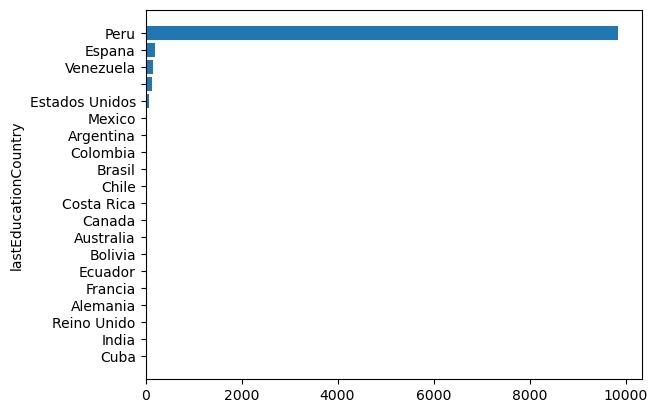

Ing. En Sistemas                  2417
Tecnologias De La Informacion     1293
Adm. De Empresas                  1159
Ing. Informatica                   644
Ing. Industrial                    507
Computacion / Informatica          491
Marketing / Comercializacion       369
Recursos Humanos / Relac. Ind.     359
Otra                               358
Psicologia                         349
                                   211
Ing. - Otros                       200
Trabajo Social                     158
Analisis De Sistemas               147
Ing. Telecomunicaciones            131
Programacion                       122
Telecomunicaciones                 119
Procesos / Calidad Total           114
Finanzas                            99
Bachiller                           96
Name: lastEducationArea, dtype: int64


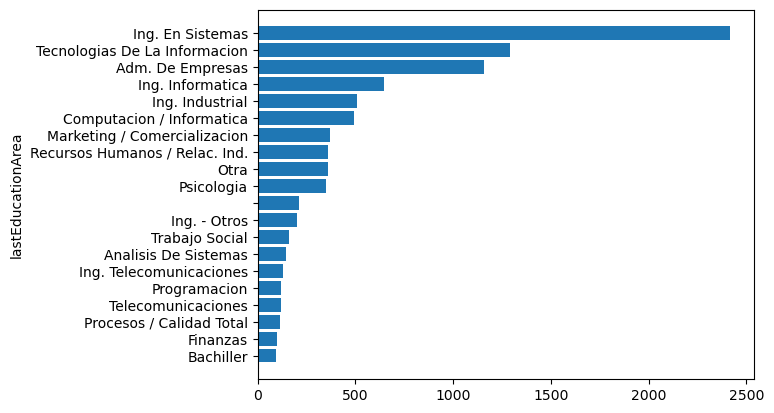

Ingenieria De Sistemas                       821
Ingenieria Industrial                        275
Psicologia                                   252
Administracion De Empresas                   195
Ingeniero De Sistemas                        192
Computacion E Informatica                    173
Ingenieria De Sistemas E Informatica         159
                                             132
Administracion                               128
Bachiller En Ingenieria De Sistemas           92
Trabajo Social                                70
Mba                                           68
Ingenieria Informatica                        63
Ingenieria De Redes Y Comunicaciones          61
Ingles                                        58
Ingenieria De Software                        56
Ingenieria De Computacion Y Sistemas          54
Administracion Y Negocios Internacionales     54
Marketing                                     53
Ingenieria De Sistemas De Informacion         51
Name: lastEducationN

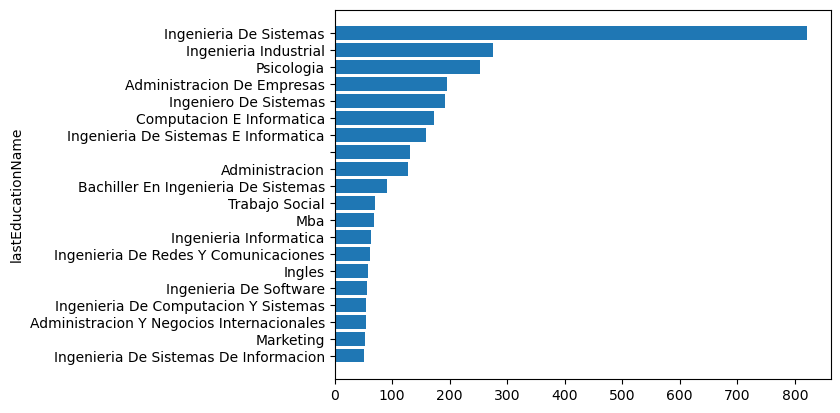

Graduado      6886
En Curso      3405
Abandonado     177
               129
Name: lastEducationStatus, dtype: int64


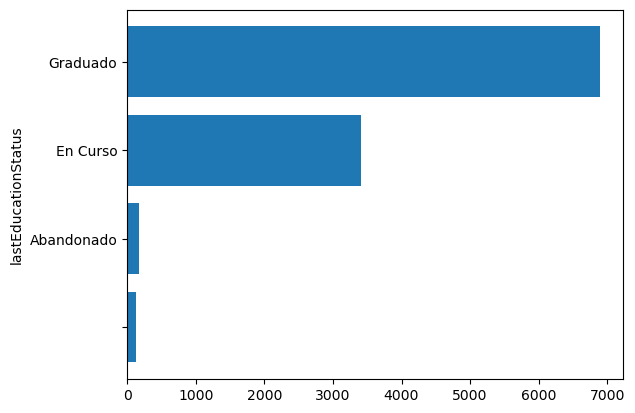

Universitario        5167
Otro                 2360
Posgrado             1257
Terciario/Tecnico    1034
Master                627
                      128
Doctorado              13
Secundario             11
Name: lastEducationDegree, dtype: int64


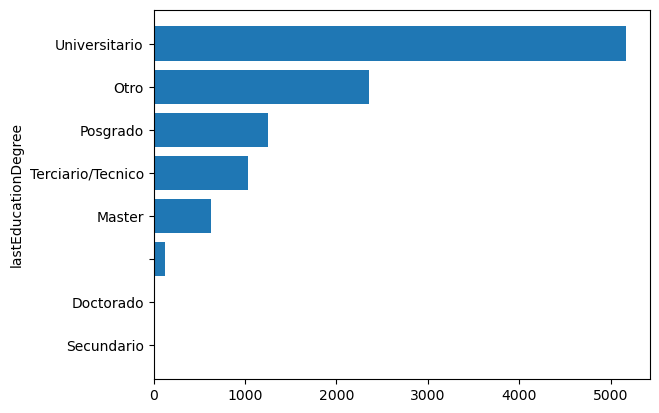

5.3    330
4.8    329
6.3    279
5.8    256
4.7    245
5.0    208
6.8    204
4.9    200
7.8    182
5.9    179
5.7    178
5.4    163
7.3    162
7.4    154
6.5    149
4.5    140
8.3    133
0.0    132
6.9    129
6.7    127
Name: yearsOfStudy, dtype: int64


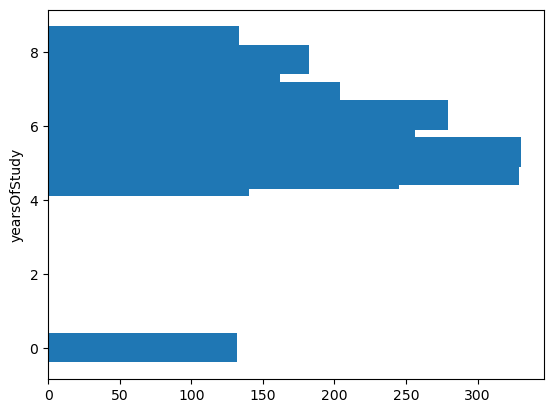

1.0     3918
2.0     2440
3.0     1217
4.0      734
5.0      492
6.0      442
7.0      304
8.0      197
9.0      152
0.0      128
11.0     121
10.0      97
12.0      72
14.0      57
13.0      45
16.0      25
15.0      23
17.0      19
18.0      19
20.0      19
Name: studiesNumber, dtype: int64


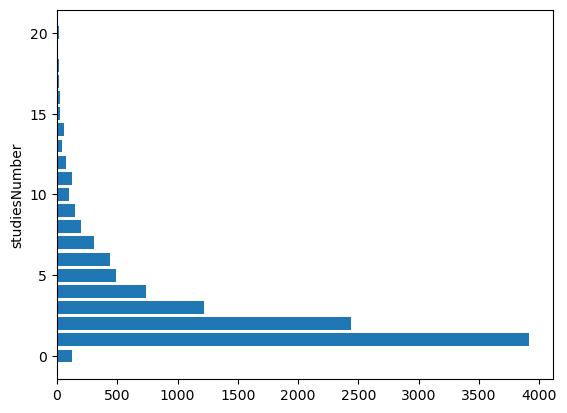

0.0     1250
1.0     1153
3.0      880
2.0      828
4.0      709
5.0      613
6.0      546
7.0      512
9.0      469
8.0      445
11.0     355
10.0     351
12.0     270
13.0     251
16.0     246
14.0     193
15.0     166
17.0     129
18.0     127
21.0      92
Name: technicalSkills, dtype: int64


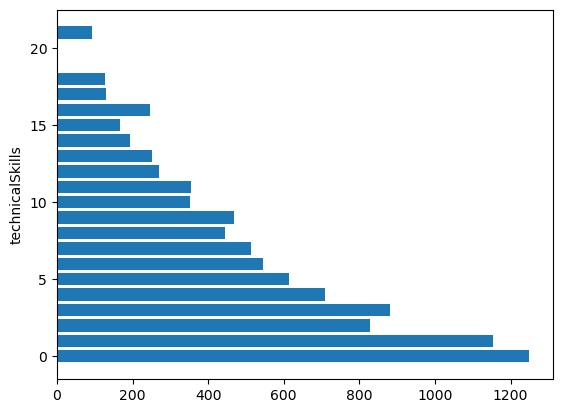

1.0    7381
2.0    2054
0.0     787
3.0     316
4.0      58
5.0       1
Name: languages, dtype: int64


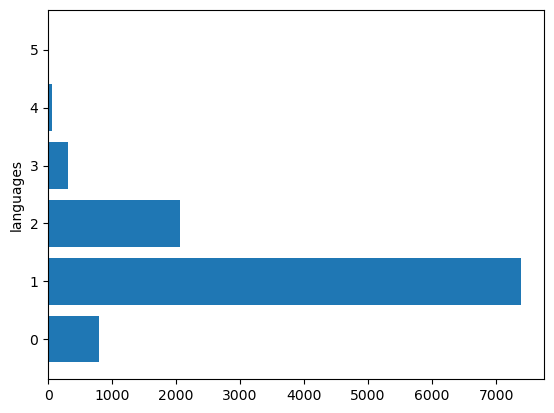

0.0     2423
1.0     1789
2.0     1209
3.0      871
4.0      777
5.0      665
6.0      523
7.0      450
8.0      360
9.0      280
10.0     228
11.0     184
12.0     152
13.0     123
14.0      98
15.0      74
17.0      55
16.0      50
20.0      38
19.0      35
Name: otherSkills, dtype: int64


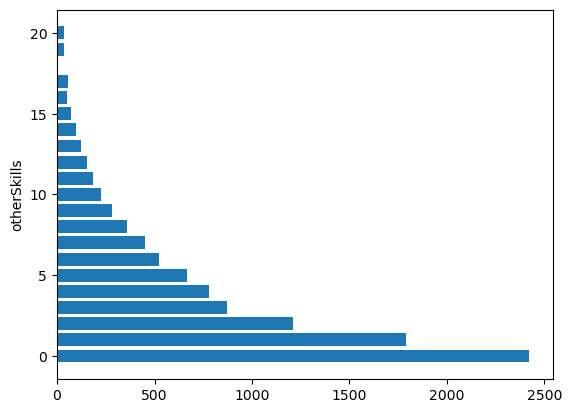

1    7647
0    2950
Name: hired, dtype: int64


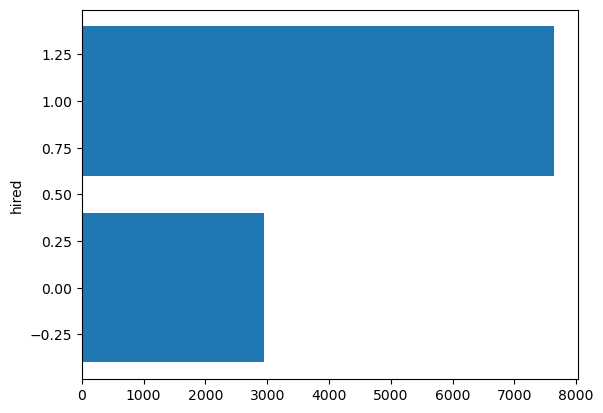

Fin: 2023-05-25 03:19:40.582950
Tiempo: 0:02:04.188799


In [143]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # El dataset principal que sea el de bumeran
  # Los otros archivos que solo se usen para actualizar la variable objetivo
  # Esto porque los otros orígenes están incompletos y costaría llenar los campos (incluso el excel que se hizo)
  
  isLoadedBumeran = True

  isLoadedEmailData = True
  isLoadedCovidData = True
  isLoadedGysAdData = True
  isLoadedAzureAdData = True
  isLoadedHomeworkingData = True
  isLoadedIllness = True
  isLoadedPermission = True
  isLoadedVacation = True

  isTaggedData = False

  # Proceso 1: Leyendo o calculando bumeran
  bumeranData = readJson(os.path.join(processMainFolder, 'bumeran.json')) if isLoadedBumeran else readAndWriteMain('bumeran')
  print("Se terminó de procesar Bumeran")

  # Proceso 2: Leyendo o calculando los archivos de apoyo
  azureAdData = readJson(os.path.join(processSupportFolder, 'azure-ad.json')) if isLoadedAzureAdData else readAndWriteSupport(inputAzureAdFolder, 'azure-ad.csv', 'azure-ad.json', readEncoding='utf-8-sig')
  print("Se terminó de procesar azureAd")

  covidData = readJson(os.path.join(processSupportFolder, 'covid.json')) if isLoadedCovidData else readAndWriteSupport(inputCovidFolder, 'covid.csv', 'covid.json', 'windows-1252')
  print("Se terminó de procesar covid")

  emailsData = readJson(os.path.join(processSupportFolder, 'email.json')) if isLoadedEmailData else readAndWriteSupport(inputEmailsFolder, 'email.csv', 'email.json', 'windows-1252')
  print("Se terminó de procesar email")

  gysAdData = readJson(os.path.join(processSupportFolder, 'gys-ad.json')) if isLoadedGysAdData else readAndWriteSupport(inputGysAdFolder, 'gys-ad.csv', 'gys-ad.json', readEncoding='utf-8-sig')
  print("Se terminó de procesar gysAd")

  homeworkingData = readJson(os.path.join(processSupportFolder, 'homeworking.json')) if isLoadedHomeworkingData else readAndWriteSupport(inputHomeworkingFolder, 'homeworking.csv', 'homeworking.json', 'windows-1252')
  print("Se terminó de procesar Homeworking")

  illnessData = readJson(os.path.join(processSupportFolder, 'illness.json')) if isLoadedIllness else readAndWriteRequests("illness", 'illness.json', "utf-16-le", 'windows-1252')
  print("Se terminó de procesar Illness")

  permissionData = readJson(os.path.join(processSupportFolder, 'permission.json')) if isLoadedPermission else readAndWriteRequests("permission", 'permission.json', "utf-16-le", 'windows-1252')
  print("Se terminó de procesar Permission")

  vacationData = readJson(os.path.join(processSupportFolder, 'vacation.json')) if isLoadedVacation else readAndWriteRequests("vacation", 'vacation.json', "utf-16-le", 
  'windows-1252')
  print("Se terminó de procesar Vacation")

  # Proceso 3: Leyendo o calculando la data etiquetada
  taggedData = readJson(os.path.join(outputFolder, 'result.json')) if isTaggedData else readAndWriteTaggedData(bumeranData, emailsData, covidData, gysAdData, azureAdData, homeworkingData, illnessData, permissionData, vacationData)
  print("Se terminó de etiquetar la data principal")

  visualizeData(taggedData)
  
  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

if __name__ == "__main__":
  main()